In [1]:
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, grey_dilation, grey_erosion, binary_closing, binary_opening, binary_dilation, label, binary_erosion
from skimage.filters import threshold_otsu
from skimage.feature import canny


--- Analyzing file: CMRA_HV1.mat ---
New best ring found on slice 0 with score: 0.0528
New best ring found on slice 1 with score: 0.0982
New best ring found on slice 2 with score: 0.1040
New best ring found on slice 3 with score: 0.1568
New best ring found on slice 7 with score: 0.1575
New best ring found on slice 8 with score: 0.1625
New best ring found on slice 10 with score: 0.1727
New best ring found on slice 19 with score: 0.2538
New best ring found on slice 108 with score: 0.2576
New best ring found on slice 112 with score: 0.3918
New best ring found on slice 119 with score: 0.4080
New best ring found on slice 120 with score: 0.4611

--- Analyzing file: CMRA_HV2.mat ---
New best ring found on slice 0 with score: 0.0426
New best ring found on slice 1 with score: 0.1171
New best ring found on slice 3 with score: 0.1255
New best ring found on slice 9 with score: 0.2202
New best ring found on slice 19 with score: 0.2740
New best ring found on slice 108 with score: 0.3800
New best ri

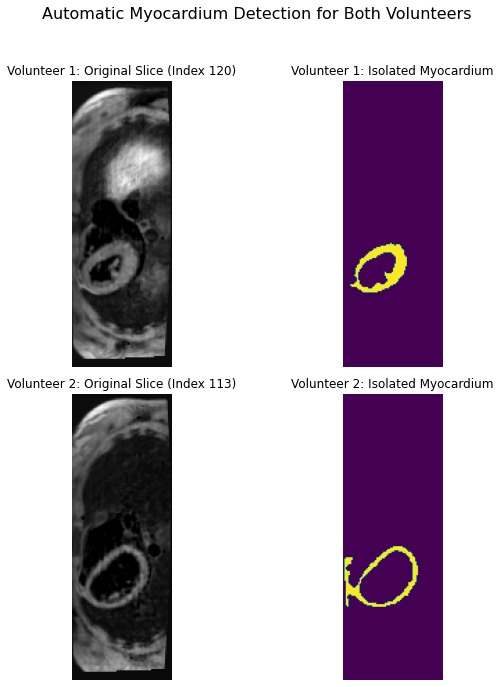

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, binary_opening, binary_erosion
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import os

def find_best_ring_in_slice(image_slice, min_area=100):
    """
    Processes a single 2D image slice to find the most 'ring-like' object.
    (This function is unchanged from the previous version)
    """
    processed_slice = median_filter(image_slice, size=3)
    if processed_slice.max() == 0:
        return None, 0.0
    binary_mask = processed_slice > threshold_otsu(processed_slice)
    opened_mask = binary_opening(binary_mask, iterations=1)
    eroded_mask = binary_erosion(opened_mask, iterations=1)
    labeled_blobs, num_labels = label(eroded_mask, return_num=True)
    if num_labels < 1:
        return None, 0.0
    properties = regionprops(labeled_blobs)
    all_labels = np.array([p.label for p in properties])
    all_areas = np.array([p.area for p in properties])
    all_filled_areas = np.array([p.filled_area for p in properties]) + 1e-6
    large_enough_indices = np.where(all_areas > min_area)[0]
    if len(large_enough_indices) == 0:
        return None, 0.0
    large_blob_labels = all_labels[large_enough_indices]
    large_blob_areas = all_areas[large_enough_indices]
    large_blob_filled_areas = all_filled_areas[large_enough_indices]
    hollowness_ratios = (large_blob_filled_areas - large_blob_areas) / large_blob_filled_areas
    if len(hollowness_ratios) > 0:
        max_hollowness = np.max(hollowness_ratios)
        best_ring_index_in_list = np.argmax(hollowness_ratios)
        the_ring_label = large_blob_labels[best_ring_index_in_list]
        best_ring_mask = np.isin(labeled_blobs, the_ring_label)
        return best_ring_mask, max_hollowness
    else:
        return None, 0.0

def analyze_volunteer(file_path):
    """
    Loads a 3D MRI .mat file and runs the full analysis to find the best slice.
    """
    print(f"\n--- Analyzing file: {os.path.basename(file_path)} ---")
    
    # Use the correct key for each file ('HV1_black' or 'HV2_black')
    file_key = 'HV1_black' if 'HV1' in file_path else 'HV2_black'

    with h5py.File(file_path, 'r') as f:
        image_3d = f[file_key][:]
        image_3d = np.transpose(image_3d, (2, 1, 0))

    best_slice_index = -1
    max_score = 0.0
    best_mask_found = None

    for i in range(image_3d.shape[0]):
        current_slice = image_3d[i, :, :]
        current_mask, current_score = find_best_ring_in_slice(current_slice)
        if current_score > max_score:
            max_score = current_score
            best_slice_index = i
            best_mask_found = current_mask
            print(f"New best ring found on slice {i} with score: {max_score:.4f}")
            
    if best_slice_index != -1:
        return {
            "original_image": image_3d[best_slice_index, :, :],
            "final_mask": best_mask_found,
            "slice_index": best_slice_index,
            "file_name": os.path.basename(file_path)
        }
    else:
        print(f"Could not find a suitable ring in {os.path.basename(file_path)}")
        return None

# --- Main Script ---

# 1. Define the list of files to process
folder_path = 'Datos_Proyecto_Final/'
volunteer_files = [
    os.path.join(folder_path, 'CMRA_HV1.mat'),
    os.path.join(folder_path, 'CMRA_HV2.mat')
]

# 2. Run the analysis for each file and store the results
results = []
for file in volunteer_files:
    if os.path.exists(file):
        result = analyze_volunteer(file)
        if result:
            results.append(result)
    else:
        print(f"File not found: {file}")

# 3. Plot the results in a 2x2 grid if both analyses were successful
if len(results) == 2:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Automatic Myocardium Detection for Both Volunteers', fontsize=16)

    # Plot results for Volunteer 1
    axes[0, 0].imshow(results[0]["original_image"], cmap='gray')
    axes[0, 0].set_title(f'Volunteer 1: Original Slice (Index {results[0]["slice_index"]})')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(results[0]["final_mask"], cmap='viridis')
    axes[0, 1].set_title('Volunteer 1: Isolated Myocardium')
    axes[0, 1].axis('off')

    # Plot results for Volunteer 2
    axes[1, 0].imshow(results[1]["original_image"], cmap='gray')
    axes[1, 0].set_title(f'Volunteer 2: Original Slice (Index {results[1]["slice_index"]})')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(results[1]["final_mask"], cmap='viridis')
    axes[1, 1].set_title('Volunteer 2: Isolated Myocardium')
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

elif len(results) > 0:
    print("Analysis was only successful for one volunteer. Displaying single result.")
    # (Add code to plot single result if you wish)
else:
    print("Analysis failed for both volunteers. No plot to display.")


--- Analyzing file: CMRA_HV1.mat ---
Best ring found on slice 120 with score: 0.4611
Thickness Statistics:
  Mean: 7.64 mm
  Std Dev: 3.19 mm

--- Analyzing file: CMRA_HV2.mat ---
Best ring found on slice 113 with score: 0.6612
Thickness Statistics:
  Mean: 4.34 mm
  Std Dev: 1.06 mm


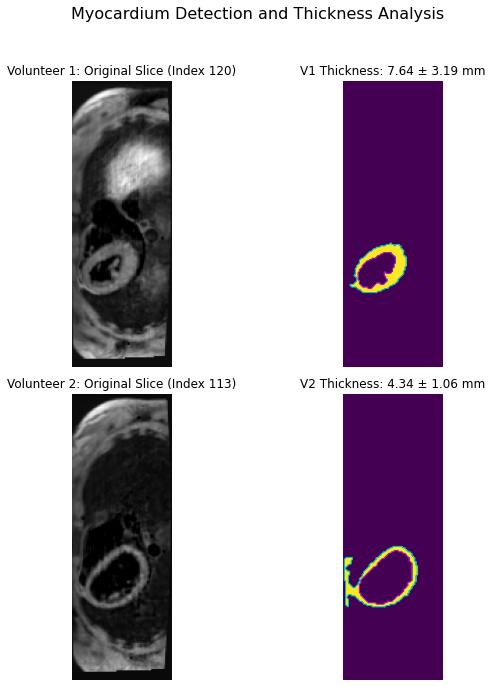

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, binary_opening, binary_erosion
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops, find_contours
from scipy.spatial.distance import cdist
import os

def find_best_ring_in_slice(image_slice, min_area=100):
    """Processes a single 2D image slice to find the most 'ring-like' object."""
    processed_slice = median_filter(image_slice, size=3)
    if processed_slice.max() == 0:
        return None, 0.0
    binary_mask = processed_slice > threshold_otsu(processed_slice)
    opened_mask = binary_opening(binary_mask, iterations=1)
    eroded_mask = binary_erosion(opened_mask, iterations=1)
    labeled_blobs, num_labels = label(eroded_mask, return_num=True)
    if num_labels < 1:
        return None, 0.0
    properties = regionprops(labeled_blobs)
    all_labels = np.array([p.label for p in properties])
    all_areas = np.array([p.area for p in properties])
    all_filled_areas = np.array([p.filled_area for p in properties]) + 1e-6
    large_enough_indices = np.where(all_areas > min_area)[0]
    if len(large_enough_indices) == 0:
        return None, 0.0
    large_blob_labels = all_labels[large_enough_indices]
    large_blob_areas = all_areas[large_enough_indices]
    large_blob_filled_areas = all_filled_areas[large_enough_indices]
    hollowness_ratios = (large_blob_filled_areas - large_blob_areas) / large_blob_filled_areas
    if len(hollowness_ratios) > 0:
        max_hollowness = np.max(hollowness_ratios)
        best_ring_index_in_list = np.argmax(hollowness_ratios)
        the_ring_label = large_blob_labels[best_ring_index_in_list]
        best_ring_mask = np.isin(labeled_blobs, the_ring_label)
        return best_ring_mask, max_hollowness
    else:
        return None, 0.0

def calculate_thickness_from_mask(mask, resolution_mm):
    """Calculates myocardial thickness from a 2D boolean mask."""
    contours = find_contours(mask, 0.5)
    if len(contours) < 2:
        return None, None # Not a ring shape
    
    contours.sort(key=len, reverse=True)
    outer_contour = contours[0]
    inner_contour = contours[1]
    
    distance_matrix = cdist(inner_contour, outer_contour)
    thickness_in_pixels = distance_matrix.min(axis=1)
    thickness_in_mm = thickness_in_pixels * resolution_mm
    
    stats = {
        "mean": np.mean(thickness_in_mm),
        "std": np.std(thickness_in_mm),
        "min": np.min(thickness_in_mm),
        "max": np.max(thickness_in_mm)
    }
    # Also return contours for plotting
    return stats, (inner_contour, outer_contour)


def analyze_volunteer(file_path):
    """
    Orchestrates the full analysis for a single volunteer file:
    1. Finds the best ring mask.
    2. Calculates thickness from that mask.
    """
    print(f"\n--- Analyzing file: {os.path.basename(file_path)} ---")
    resolution_mm = 1.5 # As per project description
    
    file_key = 'HV1_black' if 'HV1' in file_path else 'HV2_black'
    with h5py.File(file_path, 'r') as f:
        image_3d = f[file_key][:]
        image_3d = np.transpose(image_3d, (2, 1, 0))

    best_slice_index, max_score, best_mask_found = -1, 0.0, None
    for i in range(image_3d.shape[0]):
        current_mask, current_score = find_best_ring_in_slice(image_3d[i, :, :])
        if current_score > max_score:
            max_score = current_score
            best_slice_index = i
            best_mask_found = current_mask
            
    if best_slice_index != -1:
        print(f"Best ring found on slice {best_slice_index} with score: {max_score:.4f}")
        thickness_stats, contours = calculate_thickness_from_mask(best_mask_found, resolution_mm)
        
        if thickness_stats:
            print("Thickness Statistics:")
            print(f"  Mean: {thickness_stats['mean']:.2f} mm")
            print(f"  Std Dev: {thickness_stats['std']:.2f} mm")
            return {
                "original_image": image_3d[best_slice_index, :, :],
                "final_mask": best_mask_found,
                "slice_index": best_slice_index,
                "stats": thickness_stats,
                "contours": contours
            }
    print(f"Analysis failed for {os.path.basename(file_path)}")
    return None

# --- Main Script ---

folder_path = 'Datos_Proyecto_Final/'
volunteer_files = [os.path.join(folder_path, f) for f in ['CMRA_HV1.mat', 'CMRA_HV2.mat']]
results = [analyze_volunteer(file) for file in volunteer_files if os.path.exists(file)]
results = [res for res in results if res is not None] # Filter out failed analyses

if len(results) == 2:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Myocardium Detection and Thickness Analysis', fontsize=16)

    # Plot results for Volunteer 1
    res1 = results[0]
    axes[0, 0].imshow(res1["original_image"], cmap='gray')
    axes[0, 0].set_title(f'Volunteer 1: Original Slice (Index {res1["slice_index"]})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(res1["final_mask"], cmap='viridis')
    inner_c, outer_c = res1["contours"]
    axes[0, 1].plot(outer_c[:, 1], outer_c[:, 0], 'c-', linewidth=1)
    axes[0, 1].plot(inner_c[:, 1], inner_c[:, 0], 'm-', linewidth=1)
    axes[0, 1].set_title(f"V1 Thickness: {res1['stats']['mean']:.2f} ± {res1['stats']['std']:.2f} mm")
    axes[0, 1].axis('off')

    # Plot results for Volunteer 2
    res2 = results[1]
    axes[1, 0].imshow(res2["original_image"], cmap='gray')
    axes[1, 0].set_title(f'Volunteer 2: Original Slice (Index {res2["slice_index"]})')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(res2["final_mask"], cmap='viridis')
    inner_c, outer_c = res2["contours"]
    axes[1, 1].plot(outer_c[:, 1], outer_c[:, 0], 'c-', linewidth=1)
    axes[1, 1].plot(inner_c[:, 1], inner_c[:, 0], 'm-', linewidth=1)
    axes[1, 1].set_title(f"V2 Thickness: {res2['stats']['mean']:.2f} ± {res2['stats']['std']:.2f} mm")
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nCould not successfully complete the analysis for both volunteers.")